In [79]:
import json
import requests
from sklearn.decomposition import PCA
from pandas.io.json import json_normalize


In [231]:
import numpy as np
import matplotlib.pyplot as plt


In [47]:
import os
import time
import numpy as np
import pandas as pd
from pandas import ExcelWriter
from pandas import ExcelFile
import string
import random
from IPython.core.display import display, HTML
import datetime

display(HTML("<style>.container { width:100% !important; }</style>"))

# (2020-05-05)

# An Exploratory Analysis of FDA Adverse Events Data

## Logistics

###### Prompt:

The U.S. Food and Drug Administration (FDA) regulates over-the-counter and prescription drugs in the United States, including biological therapeutics and generic drugs. This work covers more than just medicines. For example, fluoride toothpaste, antiperspirants, dandruff shampoos and sunscreens are all considered drugs. 
 
An adverse event is submitted to the FDA to report any undesirable experience associated with the use of a medical product in a patient. For drugs, this includes serious drug side effects, product use errors, product quality problems, and therapeutic failures for prescription or over-the-counter medicines and medicines administered to hospital patients or at outpatient infusion centers. 
 
The FDA's database of adverse event reports is made available through a web API at https://open.fda.gov/apis/try-the-api/ Each report contains general information about the report, patient information, a list of the drugs that the patient is taking, and a list of the patient reactions.  It is possible to use these data in many ways: your brief is to explore these data and to see what might be learned from them.  As a guide, you might consider a practical solution to one of the following questions: 

- Are different adverse events reported in different countries? 
- What are the different adverse events associated with different disease areas? 
- What drugs tend to be taken together? 
 
You should publish your code to your personal github repository and send a link two days before interview.  At interview you should expect to discuss your code, any statistics or visualizations you may have used, limitations of the underlying data, and how your solution could be generalized, extended, and made into a robust product.

###### Things To Do:

* [X] explore the data in FAERS
* [X] code for connecting to the API, querying and fetching results
- [x] GitHub repo: "fda_adverse_events" or maybe "azn_cs_faers" -> is it too cryptic?
- [ ] code for reading JSONs
- [ ] slidedeck
    - discuss code
    - explain stats & visualizations
    - discuss limitations of the data
    - explain findings
    - potential generalization, extension, and further development into a robust product
- [ ] email the GitHub repo (Saturday? Sunday?)
- [ ] rehearse presentation

###### Things To Do:

* ✅ explore the data in FAERS
* ✅ code for connecting to the API, querying and fetching results
- ✅ GitHub repo: "fda_adverse_events" or maybe "azn_cs_faers" -> is it too cryptic?
- ⬜️ code for reading JSONs
- ⬜️ slidedeck
    - discuss code
    - explain stats & visualizations
    - discuss limitations of the data
    - explain findings
    - potential generalization, extension, and further development into a robust product
- ⬜️ email the GitHub repo (Saturday? Sunday?)
- ⬜️ rehearse presentation

## Some Key / Relevant Variables in FAERS for this Case Study (JSON Format)

![title](images/json.png)

- `meta`
- `results`
    - `safetyreportid` : The 8-digit Safety Report ID number, also known as the case report number or case ID. The first 7 digits (before the hyphen) identify an individual report and the last digit (after the hyphen) is a checksum. This field can be used to identify or find a specific adverse event report.
    - `receivedate` : <mark>Date that the report was first received by FDA. If this report has multiple versions, this will be the date the first version was received by FDA. **DATE (FDA USES THIS IN EXAMPLE REPORTS)**</mark>
    - `transmissiondate` : Date that the record was created. This may be earlier than the date the record was received by the FDA.
    - `receiptdate` : Date that the most recent information in the report was received by FDA.
    - `patient`
        - `patient.patientonsetage` : <mark>Age of the patient when the event first occured. **AGE OF PATIENT**</mark>
        - `patient.patientsex` :  The sex of the patient. Value is one of the following: 0. Unknown, 1. Male, 2. Female
        - `patient.reaction`
            - `patient.reaction.reactionmeddrapt` : <mark>Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. **DRUG REACTION / ADVERSE EVENT TYPE**</mark>
            - `patient.reaction.reactionoutcome` :  Outcome of the reaction in reactionmeddrapt at the time of last observation. Value is one of the following: 1. Recovered/resolved, 2. Recovering/resolving, 3. Not recovered/not resolved, 4. Recovered/resolved with sequelae (consequent health issues), 5. Fatal, 6. Unknown
        - `patient.drug`
            - `patient.drug.medicinalproduct` : Drug name. This may be the valid trade name of the product (such as ADVIL or ALEVE) or the generic name (such as IBUPROFEN). This field is not systematically normalized. It may contain misspellings or idiosyncratic descriptions of drugs, such as combination products such as those used for birth control.
            - `patient.drug.openfda.brand_name` : <mark>Brand or trade name of the drug product. **DRUG NAME**</mark>
            - `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.
            - `patient.drug.openfda.manufacturer_name` : <mark>Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC **DRUG MANUFACTURER**.</mark>
            - `patient.drug.drugadministrationroute` : The drug’s route of administration.
            - `patient.drug.openfda.route` : The route of administation of the drug product.
            - `patient.drug.drugindication` :  <mark>Indication for the drug’s use. **DRUG INDICATION / DISEASE AREA**</mark>
            - `patient.drug.openfda.pharm_class_epc` : <mark>Established pharmacologic class associated with an approved indication of an active moiety (generic drug) that the FDA has determined to be scientifically valid and clinically meaningful. Takes the form of the pharmacologic class, followed by [EPC] (such as Thiazide Diuretic [EPC] or Tumor Necrosis Factor Blocker [EPC]. **DRUG CLASS**</mark>
    - `primarysource.reportercountry` : Country from which the report was submitted. *This one is in both country codes: https://datahub.io/core/country-list and in country names*
    - `occurcountry` : <mark>The name of the country where the event occurred. *This one is in country codes.* **COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**</mark>
    - `primarysourcecountry` : Country of the reporter of the event. *This one is also in country codes.*
    - `primarysource.qualification` : Category of individual who submitted the report. Value is one of the following: 1. Physician, 2. Pharmacist, 3. Other health professional, 4. Lawyer, 5. Consumer or non-health professional

## Connecting to the openFDA API

###### OpenFDA API key: 
"WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

"With an API key: 240 requests per minute, per key. 120000 requests per day, per key."

![title](images/api_call.png)

In [64]:
api_key = "WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"

In [30]:
query_start = "https://api.fda.gov/drug/event.json?api_key="+ api_key

In [14]:
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("https://api.fda.gov/drug/event.json?api_key="+ api_key+"&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [15]:
response.content

b'{\n  "meta": {\n    "disclaimer": "Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.",\n    "terms": "https://open.fda.gov/terms/",\n    "license": "https://open.fda.gov/license/",\n    "last_updated": "2020-05-02",\n    "results": {\n      "skip": 0,\n      "limit": 1,\n      "total": 11901829\n    }\n  },\n  "results": [\n    {\n      "receiptdateformat": "102",\n      "receiver": null,\n      "companynumb": "HQWYE821915MAR04",\n      "receivedateformat": "102",\n      "primarysource": null,\n      "seriousnessother": "1",\n      "transmissiondateformat": "102",\n      "fulfillexpeditecriteria": "1",\n      "safetyreportid": "4322505-4",\n      "sender": {\n        "senderorganization": "FDA-Public Use"\n      },\n      "receivedate": "20040319",\n      "patient": {\n   

In [16]:
# Make a get request to get the latest position of the international space station from the opennotify api.
response = requests.get("https://api.fda.gov/drug/event.json?search=receivedate:[20040101+TO+20081231]&limit=1")
# Print the status code of the response.
print(response.status_code)

200


In [22]:
response.content

b'{\n  "meta": {\n    "disclaimer": "Do not rely on openFDA to make decisions regarding medical care. While we make every effort to ensure that data is accurate, you should assume all results are unvalidated. We may limit or otherwise restrict your access to the API in line with our Terms of Service.",\n    "terms": "https://open.fda.gov/terms/",\n    "license": "https://open.fda.gov/license/",\n    "last_updated": "2020-05-02",\n    "results": {\n      "skip": 0,\n      "limit": 1,\n      "total": 1313656\n    }\n  },\n  "results": [\n    {\n      "receiptdateformat": "102",\n      "receiver": null,\n      "companynumb": "HQWYE821915MAR04",\n      "receivedateformat": "102",\n      "primarysource": null,\n      "seriousnessother": "1",\n      "transmissiondateformat": "102",\n      "fulfillexpeditecriteria": "1",\n      "safetyreportid": "4322505-4",\n      "sender": {\n        "senderorganization": "FDA-Public Use"\n      },\n      "receivedate": "20040319",\n      "patient": {\n    

In [ ]:
https://api.fda.gov/drug/event.json

## Parsing & Formatting JSON

In [ ]:
def query(query_end):
    query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
    response = requests.get(query_start+query_end)
    content = json.loads(response.content)
    # print(json.dumps(parsed, indent=2, sort_keys=True))
    results = pd.json_normalize(content['results'])
    return results

## Exploration

###### Let's see how many times AstraZeneca pops up:

relevant field:
- `patient.drug.openfda.manufacturer_name` : <mark>Name of manufacturer or company that makes this drug product, corresponding to the labeler code segment of the NDC **DRUG MANUFACTURER**.</mark>

In [376]:
top_manufacturers = query("&count=patient.drug.openfda.manufacturer_name.exact")

In [386]:
top_manufacturers.head(10)

,term,count
0,Mylan Pharmaceuticals Inc.,2143943
1,Aurobindo Pharma Limited,1933948
2,"Teva Pharmaceuticals USA, Inc.",1749269
3,"Actavis Pharma, Inc.",1736623
4,Cadila Healthcare Limited,1723934
5,Amneal Pharmaceuticals LLC,1671581
6,Zydus Pharmaceuticals (USA) Inc.,1649009
7,"Sun Pharmaceutical Industries, Inc.",1545861
8,Sandoz Inc,1231388
9,West-Ward Pharmaceuticals Corp.,1201469


In [387]:
top_manufacturers.tail(10)

,term,count
90,"Marc Glassman, Inc.",572098
91,Macleods Pharmaceuticals Limited,571052
92,CARDINAL HEALTH,570665
93,QUALITY CHOICE (Chain Drug Marketing Association),570167
94,"L.N.K. International, Inc.",569424
95,"P & L Development, LLC",568163
96,"ACETRIS HEALTH, LLC",566351
97,"Big Lots Stores, Inc.",564796
98,"Harris Teeter, LLC",560658
99,"MEIJER, INC.",558330


In [397]:
test = query("&search=patient.drug.openfda.manufacturer_name:\"AstraZeneca\"&count=patient.drug.openfda.manufacturer_name.exact")
test.head()

,term,count
0,AstraZeneca Pharmaceuticals LP,501107
1,Mylan Pharmaceuticals Inc.,207433
2,Aurobindo Pharma Limited,183622
3,Cadila Healthcare Limited,180199
4,Zydus Pharmaceuticals (USA) Inc.,176142


**AstraZeneca is listed as a drug manufacturer in ~500K reports, and is not among the top 100 manufacturers in terms of frequency.**

In [ ]:
# for manuf in list(test.term):
#     if "Zen" in manuf:
#         print(manuf)

## Answering Specific Questions from the Case Study

###### 1. Are different adverse events reported in different countries? 

relevant fields:
- `patient.reaction.reactionmeddrapt` : <mark>Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. **DRUG REACTION / ADVERSE EVENT TYPE**</mark>
- `occurcountry` : <mark>The name of the country where the event occurred. *This one is in country codes.* **COUNTRY (FDA USES THIS IN EXAMPLE REPORTS)**</mark>


potential ways of answering the question:
- pick top X countries, and report top X adverse events for each
- construct a matrix of top X countries vs top Y adverse events, and visualize how similar countries are in this hyperspace, (maybe PCA before that), do clustering analysis, scrutinize outliers

In [163]:
def query(query_end):
    query_start = "https://api.fda.gov/drug/event.json?api_key=WCsZXD7fwzXRDV02maz9kKLAaRzs5J8kzHSSNIgw"
    response = requests.get(query_start+query_end)
    content = json.loads(response.content)
    # print(json.dumps(parsed, indent=2, sort_keys=True))
    results = pd.json_normalize(content['results'])
    return results

In [173]:
top_countries = query("&count=occurcountry.exact")
top_countries.head(10)

,term,count
0,US,6136862
1,GB,298758
2,CA,260177
3,JP,259359
4,FR,250505
5,DE,190403
6,IT,138001
7,BR,92823
8,ES,71442
9,AU,65305


In [316]:
top_reactions = query("&count=patient.reaction.reactionmeddrapt.exact")
top_reactions.head(10)

,term,count
0,DRUG INEFFECTIVE,733191
1,NAUSEA,485098
2,DEATH,474541
3,FATIGUE,439328
4,HEADACHE,388310
5,DIARRHOEA,359872
6,DYSPNOEA,344540
7,PAIN,326354
8,OFF LABEL USE,324957
9,DIZZINESS,313617


In [ ]:
# results = query("&search=occurcountry:\"US\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

In [ ]:
# results = query("&search=occurcountry:\"CA\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

In [ ]:
# results = query("&search=occurcountry.exact:\"US\"+\"CA\"&count=patient.reaction.reactionmeddrapt.exact")
# results.head(10)

Canada & Drug Ineffective

In [368]:
results = query("&search=occurcountry.exact:\"CA\"+AND+patient.reaction.reactionmeddrapt.exact:\"DRUG INEFFECTIVE\"&count=occurcountry.exact")
results.head(10)

,term,count
0,CA,37725


Do the same for top 10 countries and top 10 reactions

In [195]:
list(top_countries.term)[:10]

['US', 'GB', 'CA', 'JP', 'FR', 'DE', 'IT', 'BR', 'ES', 'AU']

In [198]:
list(top_reactions.term)[:10]

['DRUG INEFFECTIVE',
 'NAUSEA',
 'DEATH',
 'FATIGUE',
 'HEADACHE',
 'DIARRHOEA',
 'DYSPNOEA',
 'PAIN',
 'OFF LABEL USE',
 'DIZZINESS']

In [258]:
m,n = 25,25
temp = np.zeros((m,n), dtype=np.int)
for i, reaction in enumerate(list(top_reactions.term)[:m]):
    #create drug reaction row
    for j, country in enumerate(list(top_countries.term)[:n]):
        #add country to the reaction row
        results = query("&search=occurcountry:\""+country+"\"+AND+patient.reaction.reactionmeddrapt:\""+reaction+"\"&count=patient.reaction.reactionmeddrapt.exact")
        count = int(results.head(1)["count"])
        #print(country,reaction,count)
        temp[i,j] = count

In [259]:
top25_c_by_r = pd.DataFrame(temp,columns = list(top_countries.term)[:n],index = list(top_reactions.term)[:m])

In [306]:
top25_c_by_r.head()

,US,GB,CA,JP,FR,DE,IT,BR,ES,AU,...,AR,TR,CH,PL,BE,PT,KR,MX,GR,TW
DRUG INEFFECTIVE,484075,6278,37725,4782,4820,4453,4668,7265,2266,2205,...,765,1032,749,1882,617,1170,519,648,891,324
NAUSEA,242231,11449,16993,6040,6760,7829,4146,3179,1394,1979,...,184,719,683,678,787,667,653,470,196,261
DEATH,226952,17448,18713,6515,4586,5622,2008,5495,1790,4852,...,2803,947,676,1105,1201,425,1052,2646,759,3311
FATIGUE,248898,12430,19856,1742,9701,7159,1324,3681,1050,1784,...,467,392,601,359,1041,713,188,616,356,264
HEADACHE,209207,10360,13249,2227,7506,4388,2479,4107,1045,1423,...,383,330,412,412,506,479,319,663,238,124


Normalize each cell by total number of reports per country

In [410]:
df  = top25_c_by_r

In [411]:
df=(df/df.sum())

In [299]:
# df =  df.drop(['US','GB','CA'], axis=1)

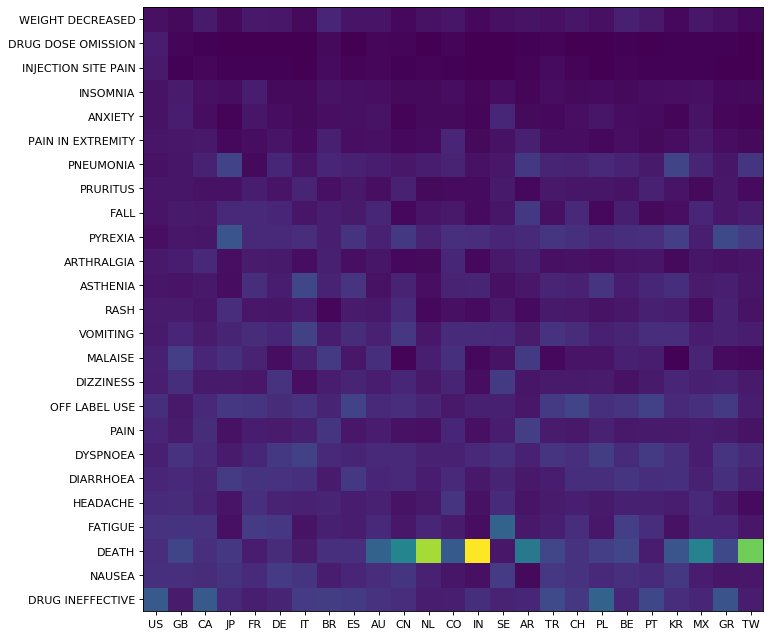

In [467]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [406]:
df  = top25_c_by_r

In [407]:
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
df=(df-df.min())/(df.max()-df.min())

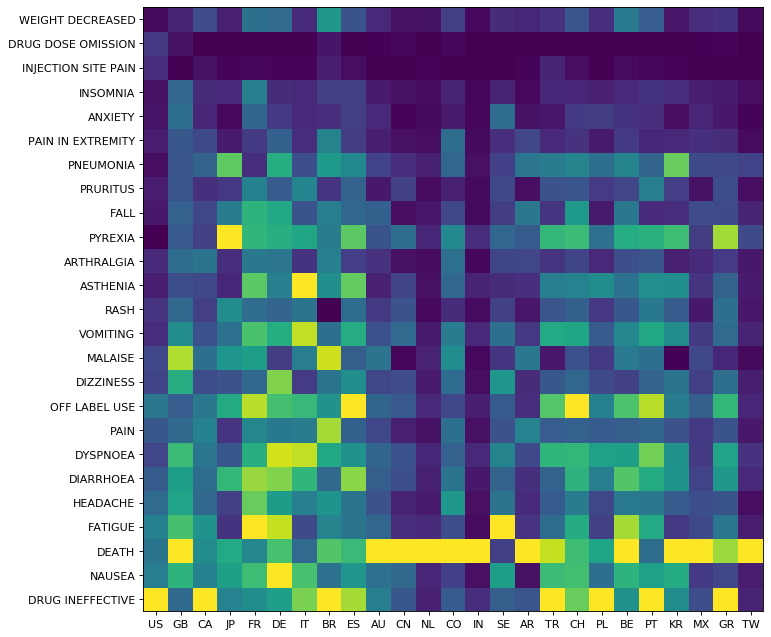

In [408]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

In [400]:
df  = top25_c_by_r

In [309]:
#normalizing like this does not make much sense: 
# normalized_df=(df-df.mean())/df.std()
df=(df-df.mean())/df.std()

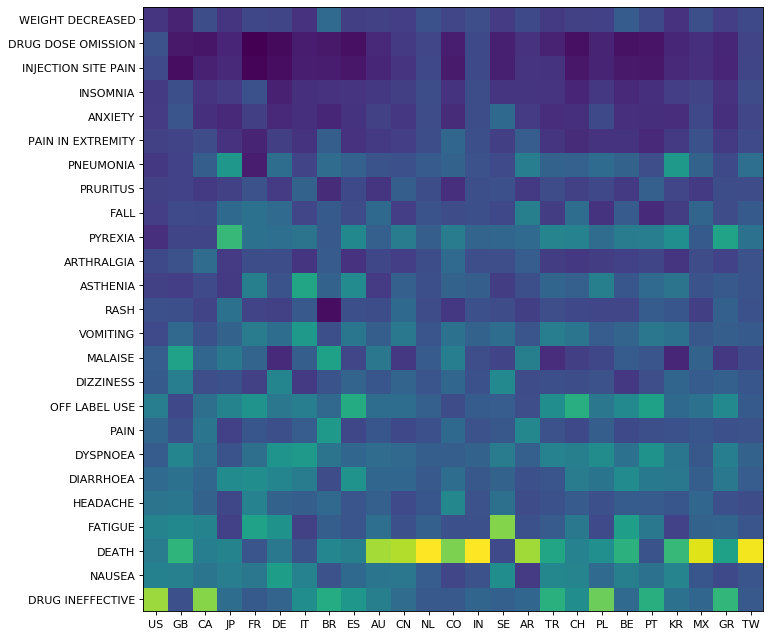

In [310]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

Which countries are similar? Maybe we can reduce the dimensions, and visulize (+calculate) clusters.

In [413]:
df  = top25_c_by_r

In [414]:
df=(df/df.sum())

In [461]:
pca = PCA(n_components=2)
df_pca = pca.fit_transform(df.T)
print(pca.components_)
print(pca.explained_variance_ratio_)

[[-0.10215425 -0.09238534  0.96899413 -0.09712213 -0.06452134 -0.06706649
  -0.04315574 -0.04169232 -0.07141346 -0.03756094 -0.0429443  -0.03052678
  -0.04216161 -0.04593108 -0.0338223   0.01375022 -0.0146195  -0.04778621
   0.0149903  -0.01276825 -0.03749151 -0.02046886 -0.01151754 -0.0100401
  -0.03058459]
 [-0.36364091 -0.09261864 -0.01063562  0.34257905  0.17981252 -0.1371389
  -0.15270643  0.18003245 -0.27499993  0.09503518  0.38532608 -0.1747326
  -0.15512013 -0.26205586  0.19477208 -0.33995008  0.20874198 -0.10946119
  -0.0542756   0.17974887  0.13681956  0.05965107  0.02695184  0.04044729
   0.09741792]]
[0.70707556 0.08735523]


In [463]:
df.shape

(25, 25)

In [464]:
df_pca.shape

(25, 2)

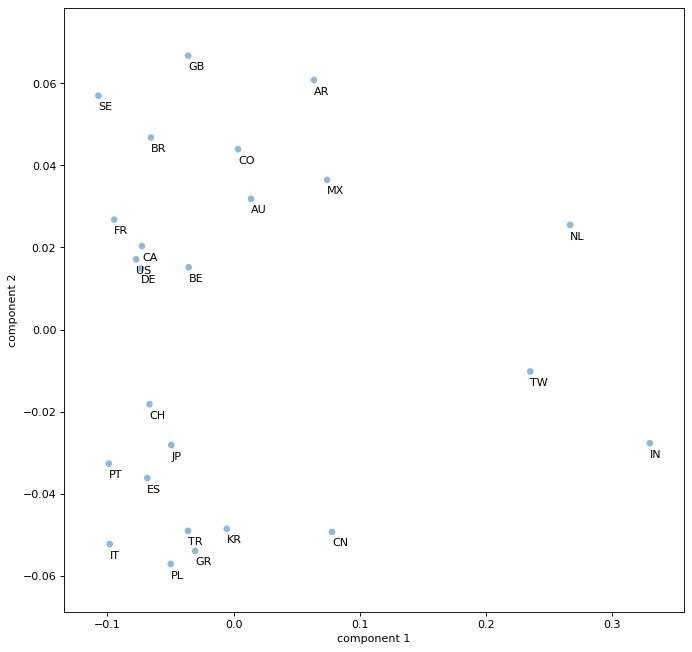

In [487]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.scatter(df_pca[:, 0], df_pca[:, 1], edgecolor='none', alpha=0.5)
plt.xlabel('component 1')
plt.ylabel('component 2')
c = 0.0035
for i, col in enumerate(df.columns):
    plt.annotate(col, (df_pca[i, 0], df_pca[i, 1]-c))

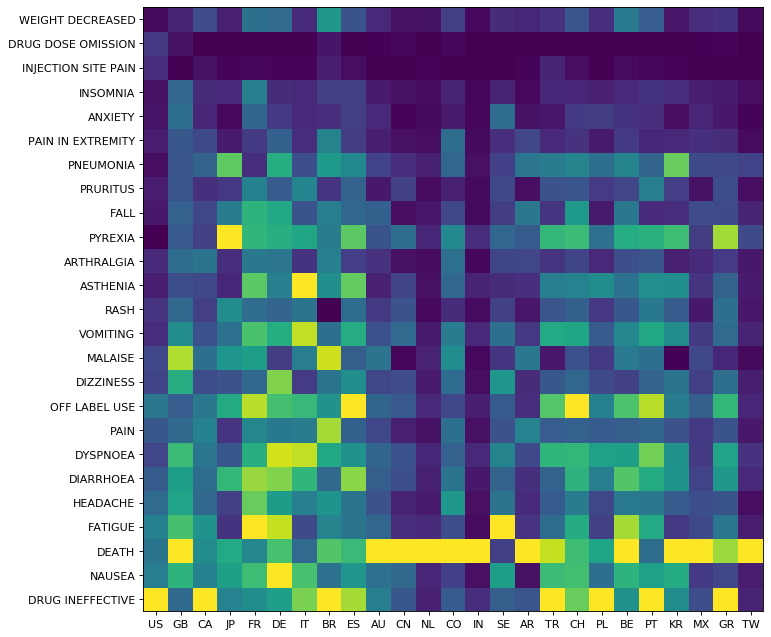

In [408]:
figure(num=None, figsize=(10, 10), dpi=80, facecolor='w', edgecolor='k')
plt.pcolor(df)
plt.yticks(np.arange(0.5, len(df.index), 1), df.index)
plt.xticks(np.arange(0.5, len(df.columns), 1), df.columns)
plt.show()

###### ANSWER:

Looks like YES.

When we do the PCA analysis, the top 2 principal components that explain 
- test test test

###### 2. What are the different adverse events associated with different disease areas?

Relevant fields:
- `patient.reaction.reactionmeddrapt` : <mark>Patient reaction, as a MedDRA term. Note that these terms are encoded in British English. For instance, diarrhea is spelled diarrohea. MedDRA is a standardized medical terminology. **DRUG REACTION / ADVERSE EVENT TYPE**</mark>          
- `patient.drug.drugindication` :  <mark>Indication for the drug’s use. **DRUG INDICATION / DISEASE AREA**</mark>

###### ANSWER:

###### 3. What drugs tend to be taken together?  

Relevant fields:
- `patient.drug.openfda.brand_name` : <mark>Brand or trade name of the drug product. **DRUG NAME**</mark>
- `patient.drug.openfda.generic_name` : Generic name(s) of the drug product.

###### ANSWER:

## Discussion & Future Directions

###### Limitations of the Data

###### ..